In [3]:
import numpy as np
import pandas as pd 
#import fbprophet 
#from fbprophet import Prophet
import plotly
import statsmodels
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot
import altair as alt
import scipy
from scipy import signal
#import spectrum 
#from spectrum import WelchPeriodogram
#from spectrum import Periodogram
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import q_stat
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import arma_order_select_ic
import statsmodels.api as sm
from math import sqrt
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [5]:
flu_data = pd.read_csv('flu.csv', header = 2, sep = ',')

In [6]:
flu_data.head(n=5)

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
0,United States of America,Region of the Americas of WHO,North America,2013,1,2012-12-31,2013-01-06,18219,18219,0.0,...,0.0,1653,5377,0,0,1097,1097,6474,NaN,Widespread Outbreak
1,United States of America,Region of the Americas of WHO,North America,2013,2,2013-01-07,2013-01-13,20013,20013,0.0,...,0.0,1767,5752,0,0,1145,1145,6897,NaN,Widespread Outbreak
2,United States of America,Region of the Americas of WHO,North America,2013,3,2013-01-14,2013-01-20,19228,19228,0.0,...,0.0,1624,4858,0,0,1078,1078,5936,NaN,Widespread Outbreak
3,United States of America,Region of the Americas of WHO,North America,2013,4,2013-01-21,2013-01-27,17139,17139,0.0,...,0.0,1528,4039,0,0,1091,1091,5130,NaN,Widespread Outbreak
4,United States of America,Region of the Americas of WHO,North America,2013,5,2013-01-28,2013-02-03,14795,14795,0.0,...,0.0,951,2963,0,0,1076,1076,4039,NaN,Widespread Outbreak


## Utility Functions

### Adapted from 

###### https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_forecasting.html

###### https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/


In [7]:
def arima_window_ase(data_series, train_ratio = .60, order = (0,0,0), seasonal_order = (0,0,0,0)): 
    X_series = data_series.values
    size = int(len(X_series)*train_ratio)
    train,test = X_series[0:size], X_series[size:len(X_series)]
    history = [i for i in train]
    preds = list()
    for t in range(len(test)): 
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        fore_cast = model_fit.forecast()
        yhat = fore_cast[0]
        preds.append(yhat)
        obs = test[t]
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, preds))
    pyplot.plot(test)
    pyplot.plot(preds, color='red')
    pyplot.show()
    
    return rmse
    print(residuals.describe())

In [8]:
def make_realization(data_frame,x,y): 
    
    vis = alt.Chart(data_frame).mark_line().encode(
    x = x, 
    y = y
    )
    
    return vis

In [9]:
def make_autocorr(data_series, nlags=40, fft = False): 
    auto_corr = statsmodels.tsa.stattools.acf(data_series, nlags=nlags, fft=fft)
    data = pd.DataFrame(list(enumerate(auto_corr)), columns = ['Lag', 'AutoCor'])
    vis = alt.Chart(data).mark_bar().encode(
    x='Lag',
    y='AutoCor',
    )
    return vis

In [10]:
def make_sig_periodgram(data_series, fs = 1, scaling = 'density'): 
    f, Pxx_den = scipy.signal.periodogram(data_series, fs = fs, scaling=scaling)
    data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
    vis = alt.Chart(data).mark_bar().encode(
        x='Freq',
        y='Density',
    )
    return vis

In [11]:
def make_welch_sig_periodgram(data_series, fs = 1, nperseg=50): 
    f, Pxx_den = scipy.signal.welch(flu_data.SPEC_RECEIVED_NB, fs = 1, nperseg=nperseg)
    data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
    vis = alt.Chart(data).mark_bar().encode(
        x='Freq',
        y='Density',
    )
    return vis

In [12]:
def make_welch_periodgram(data_series, sampling = 50):
    psd = WelchPeriodogram(data_series, sampling)
    return psd[1]

### Function call to realization generations

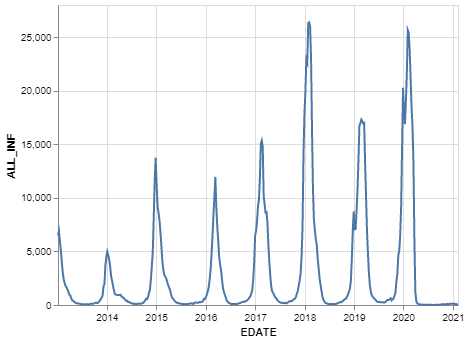

In [42]:
make_realization(flu_data, 'EDATE:T', 'ALL_INF')

### Under the hood this is what the make_realization function does

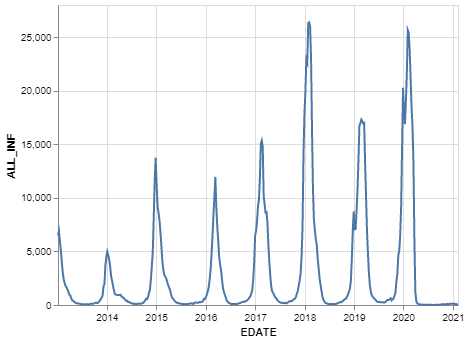

In [43]:
alt.Chart(flu_data).mark_line().encode(
    x='EDATE:T',
    y='ALL_INF'
)


### To verify if variable is a series 

In [45]:
series = flu_data.ALL_INF
series.index

RangeIndex(start=0, stop=423, step=1)

### Function call to generate autocorrelation plot
### we can see there is evidence against stationarity, there is slowly dampening sinusiodal autocorrelations

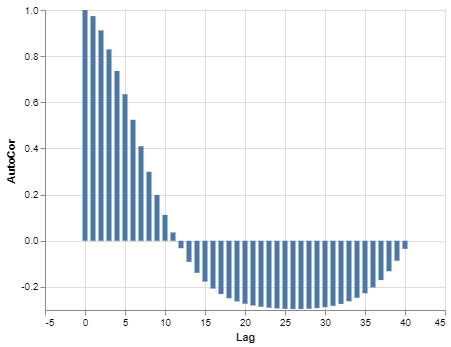

In [46]:
make_autocorr(flu_data.ALL_INF, nlags = 40)

### Under the hood this is what the make_autocorr function does

In [49]:
ALL_INF_auto_cor = statsmodels.tsa.stattools.acf(flu_data.ALL_INF)

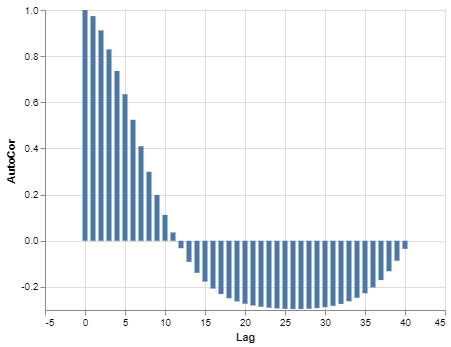

In [50]:
data = pd.DataFrame(list(enumerate(ALL_INF_auto_cor)), columns = ['Lag', 'AutoCor'])
alt.Chart(data).mark_bar().encode(
    x='Lag',
    y='AutoCor',
)

### Make function call to series periodgram to see if underlying frequency exists

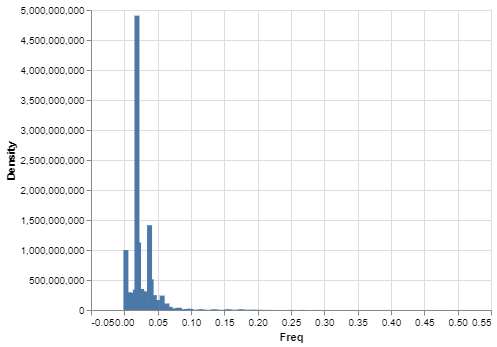

In [51]:
make_sig_periodgram(flu_data.ALL_INF)

### ### Under the hood this is what the make_sig_periodgram function does

In [52]:
f, Pxx_den = scipy.signal.periodogram(flu_data.ALL_INF, fs = 1, scaling='density')

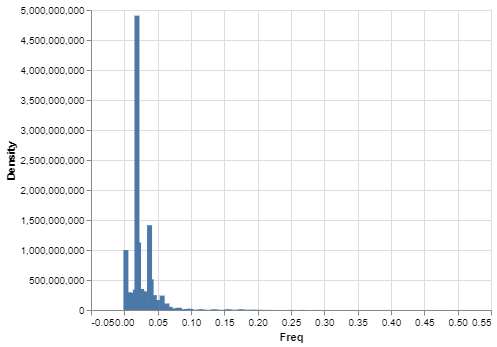

In [53]:
data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
alt.Chart(data).mark_bar().encode(
    x='Freq',
    y='Density',
)

### make function call to make_welch_sig_perdiogram function

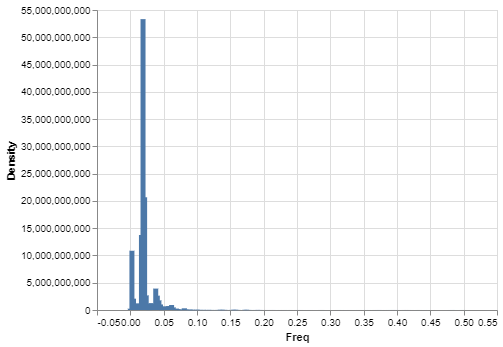

In [54]:
make_welch_sig_periodgram(flu_data.ALL_INF, fs = 1, nperseg=420)

### Under the hood this is what the make_realization function does

In [55]:
f, Pxx_den = scipy.signal.welch(flu_data.ALL_INF, fs = 1, nperseg=420)

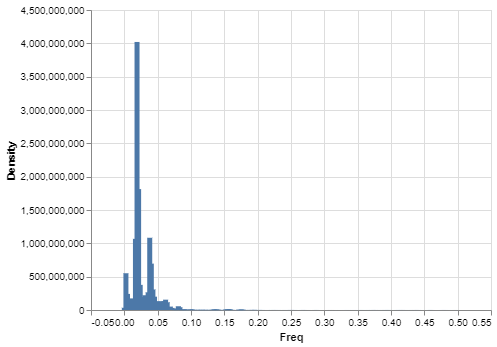

In [56]:
data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
alt.Chart(data).mark_bar().encode(
    x='Freq',
    y='Density',
)

### function call to welch Power Spectral Density plot function 

In [57]:
make_welch_periodgram(flu_data.ALL_INF,sampling = 50)

NameError: name 'WelchPeriodogram' is not defined

### Under the hood this is what the make_welch_periodgram function does

In [58]:
psd = WelchPeriodogram(flu_data.ALL_INF,50)

NameError: name 'WelchPeriodogram' is not defined

In [59]:
psd = Periodogram(flu_data.ALL_INF, 50, scale_by_freq = True)
psd.plot()

NameError: name 'Periodogram' is not defined

### Lets get an estimate of our arma model structure, assuming stationarity despite evidence against

In [60]:
res = statsmodels.tsa.stattools.arma_order_select_ic(flu_data.ALL_INF, ic=["aic", "bic"], trend="nc")

In [26]:
res.aic

,0,1,2
0,NaN,9340.380969,8935.618407
1,8137.488407,8028.267909,7989.563702
2,7985.137073,7986.159993,7984.675115
3,7986.216854,7983.348112,7984.749204
4,7988.216563,7984.104760,7971.680217


In [27]:
res.aic_min_order

(4, 2)

In [28]:
res.bic

,0,1,2
0,NaN,9348.475713,8947.760524
1,8145.583151,8040.410025,8005.753190
2,7997.279190,8002.349482,8004.911976
3,8002.406343,8003.584973,8009.033437
4,8008.453424,8008.388994,8000.011822


In [29]:
res.bic_min_order

(2, 0)

### AIC and BIC differ, but we will go with BIC model structure, suggesting the errors are Gaussian, but maylook to be centered on zero. We see the errors still look correlated and there is some trend the model is not capturing. 

                               SARIMAX Results                                
Dep. Variable:       SPEC_RECEIVED_NB   No. Observations:                  423
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -3985.131
Date:                Sat, 20 Feb 2021   AIC                           7978.263
Time:                        10:04:59   BIC                           7994.452
Sample:                             0   HQIC                          7984.660
                                - 423                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.131e+04   8613.545      2.474      0.013    4428.421    3.82e+04
ar.L1          1.5316      0.024     65.133      0.000       1.485       1.578
ar.L2         -0.5602      0.022    -25.103      0.0

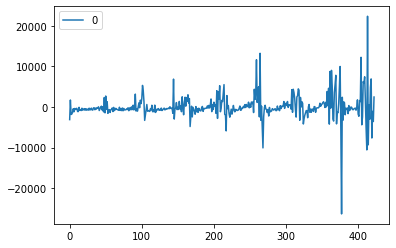

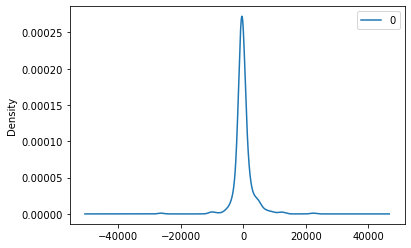

                  0
count    423.000000
mean      11.453362
std     2980.691003
min   -26331.120360
25%     -861.404582
50%     -356.491900
75%      489.911810
max    22381.314924


In [30]:
model = ARIMA(flu_data.SPEC_RECEIVED_NB, order=(2,0,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

H0: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).
Ha: The data are not independently distributed; they exhibit serial correlation.

We can see at Lag 10 there is sufficient evidence to say the residuals are not idependently distributed, and supports serial correlation. But that does not mean the model is not useful. 

In [31]:
 sm.stats.acorr_ljungbox(model_fit.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,34.945156,0.000128


### Function call to arima_window_ase
### We can see the model does follow the data well. 

In [27]:
arima_window_ase(flu_data.SPEC_RECEIVED_NB, train_ratio = .80, order=(2,0,0))

C:\Users\sabri\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sabri\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KeyboardInterrupt: 

/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


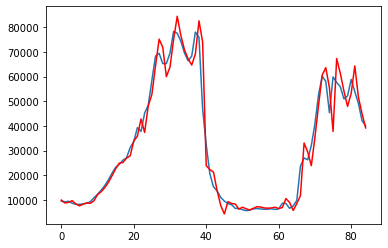

5583.778779665173

In [33]:
arima_window_ase(flu_data.SPEC_RECEIVED_NB, train_ratio = .80, order=(4,1,2))

### Under the hood this is what the arima_window_ASE does 

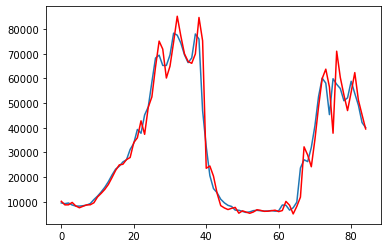

In [34]:
X = flu_data.SPEC_RECEIVED_NB.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# window MSE 
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [35]:
rmse

5682.187290641301

In [36]:
m = Prophet()
Prophet_df = flu_data[['EDATE','SPEC_RECEIVED_NB']].copy()
Prophet_df['EDATE'] = Prophet_df['EDATE'].astype('datetime64[ns]')
Prophet_df.columns = ['ds', 'y']
Prophet_df.info()
m.fit(Prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      423 non-null    datetime64[ns]
 1   y       423 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.7 KB


In [37]:
future = m.make_future_dataframe(periods=50)
future.tail()

,ds
468,2021-03-25
469,2021-03-26
470,2021-03-27
471,2021-03-28
472,2021-03-29


In [38]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
468,2021-03-25,47312.797090,35662.136984,59561.206170
469,2021-03-26,46713.763190,34153.932707,58695.716295
470,2021-03-27,46086.452479,33521.391480,58926.273918
471,2021-03-28,45434.216927,32973.651567,58173.219817
472,2021-03-29,44760.846220,33227.726494,56720.504046


########################### SABRINA ######################################

In [22]:
flu_data.head()

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
0,United States of America,Region of the Americas of WHO,North America,2013,1,2012-12-31,2013-01-06,18219,18219,0.0,...,0.0,1653,5377,0,0,1097,1097,6474,NaN,Widespread Outbreak
1,United States of America,Region of the Americas of WHO,North America,2013,2,2013-01-07,2013-01-13,20013,20013,0.0,...,0.0,1767,5752,0,0,1145,1145,6897,NaN,Widespread Outbreak
2,United States of America,Region of the Americas of WHO,North America,2013,3,2013-01-14,2013-01-20,19228,19228,0.0,...,0.0,1624,4858,0,0,1078,1078,5936,NaN,Widespread Outbreak
3,United States of America,Region of the Americas of WHO,North America,2013,4,2013-01-21,2013-01-27,17139,17139,0.0,...,0.0,1528,4039,0,0,1091,1091,5130,NaN,Widespread Outbreak
4,United States of America,Region of the Americas of WHO,North America,2013,5,2013-01-28,2013-02-03,14795,14795,0.0,...,0.0,951,2963,0,0,1076,1076,4039,NaN,Widespread Outbreak


In [61]:
acf(flu_data.ALL_INF)

C:\Users\sabri\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([ 1.        ,  0.97340255,  0.91161694,  0.82928864,  0.73597795,
        0.6349297 ,  0.52424732,  0.40975496,  0.29893333,  0.19859855,
        0.1119284 ,  0.03595709, -0.03226184, -0.09113685, -0.13894138,
       -0.17683985, -0.20683848, -0.23069557, -0.24896327, -0.26266285,
       -0.2727453 , -0.28017243, -0.28574246, -0.28991645, -0.29292166,
       -0.29497416, -0.29601989, -0.29585006, -0.29452285, -0.29193081,
       -0.28779058, -0.28180849, -0.27339102, -0.26211158, -0.24697497,
       -0.22725203, -0.20190621, -0.17037865, -0.13187261, -0.08643847,
       -0.03504717])

In [62]:
statsmodels.tsa.stattools.adfuller(flu_data.ALL_INF)

(-5.118847930322406,
 1.2845833630233787e-05,
 14,
 408,
 {'1%': -3.446479704252724,
  '5%': -2.8686500930967354,
  '10%': -2.5705574627547096},
 6617.007967071611)

In [63]:
flu_d1 = statsmodels.tsa.statespace.tools.diff(flu_data.ALL_INF, k_diff=1)

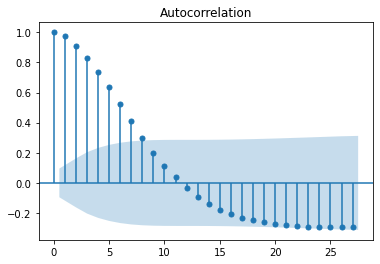

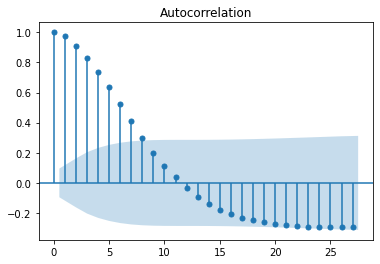

In [64]:
statsmodels.graphics.tsaplots.plot_acf(flu_data.ALL_INF)

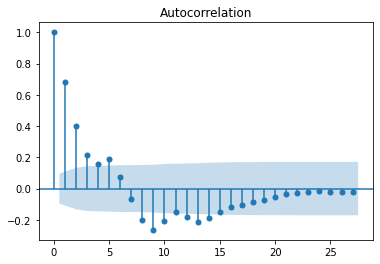

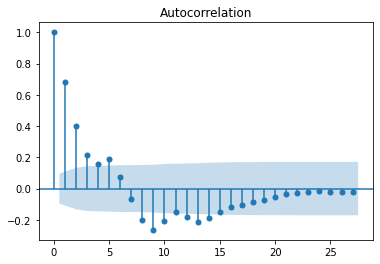

In [65]:
statsmodels.graphics.tsaplots.plot_acf(flu_d1)

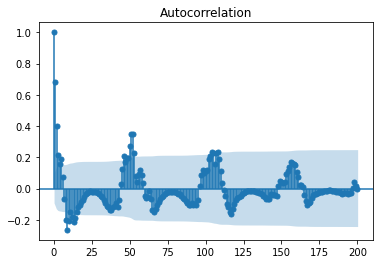

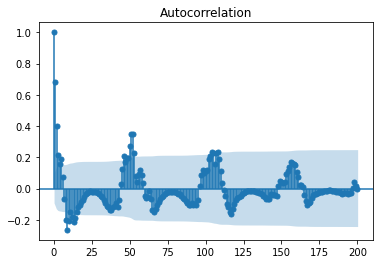

In [66]:
statsmodels.graphics.tsaplots.plot_acf(flu_d1, lags = 200) #by expanding out the lags, I can see the 52 week (annual) seasonality

In [67]:
#Now I want to factor out the seasonality
flu_d1_s52 = statsmodels.tsa.statespace.tools.diff(flu_d1, seasonal_periods=52)

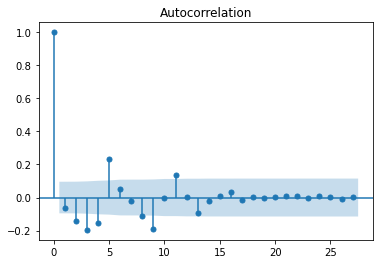

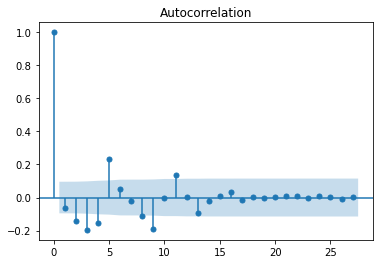

In [68]:
statsmodels.graphics.tsaplots.plot_acf(flu_d1_s52)

In [69]:
#now we run aic to find the arma components
#expanded out the phi and theta thresholds since prior runs maximized both 
res = statsmodels.tsa.stattools.arma_order_select_ic(flu_d1_s52, max_ar=10, max_ma=5, ic=["aic","bic"])

C:\Users\sabri\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\sabri\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\sabri\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\sabri\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\sabri\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no b

In [71]:
res.aic

,0,1,2,3,4,5
0,7014.479815,7013.792786,6993.088802,6961.528459,6938.155233,6937.528199
1,7014.688496,6949.655425,6947.048814,6945.888274,6934.888965,6936.888942
2,7007.504129,6946.538058,6948.470708,6947.568305,6936.888923,6936.707146
3,6988.291797,6980.203891,6971.873032,6931.728881,6966.799906,6968.685717
4,6967.976643,6963.486306,6963.812226,6965.697808,6965.749149,6931.583884
5,6961.905733,6963.878385,6965.566976,6929.300581,6932.209332,6925.252808
6,6963.865221,6920.135906,6911.777137,6931.261797,6932.739566,6903.078654
7,6965.317048,6916.731157,6900.131906,6901.280765,6932.826600,6918.099232
8,6965.181392,6914.685061,6915.565489,6903.474225,6914.779078,6908.018336
9,6956.099823,6914.796918,6916.554757,6907.003484,6898.387393,6911.230013


In [72]:
res.aic_min_order

(9, 4)

In [73]:
res.bic

,0,1,2,3,4,5
0,7022.565081,7025.920685,7009.259333,6981.741623,6962.411030,6965.826629
1,7026.816394,6965.825956,6967.261978,6970.144071,6963.187395,6969.230004
2,7023.674660,6966.751223,6972.726505,6975.866735,6969.229986,6973.090842
3,7008.504961,7004.459688,7000.171462,6964.069943,7003.183602,7009.112045
4,6992.232440,6991.784736,6996.153288,7002.081504,7006.175477,6976.052845
5,6990.204163,6996.219448,7001.950672,6969.726909,6976.678294,6973.764402
6,6996.206284,6956.519601,6952.203465,6975.730758,6981.251160,6955.632881
7,7001.700743,6957.157486,6944.600867,6949.792359,6985.380827,6974.696092
8,7005.607720,6959.154022,6964.077083,6956.028452,6971.375938,6968.657828
9,7000.568784,6963.308512,6969.108984,6963.600344,6959.026885,6975.912138


In [74]:
res.bic_min_order

(7, 2)

C:\Users\sabri\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


                                     SARIMAX Results                                      
Dep. Variable:                            ALL_INF   No. Observations:                  423
Model:             ARIMA(9, 1, 4)x(1, 1, [1], 52)   Log Likelihood               -3056.243
Date:                            Sun, 21 Feb 2021   AIC                           6144.485
Time:                                    20:28:54   BIC                           6207.102
Sample:                                         0   HQIC                          6169.357
                                            - 423                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7064      0.976      0.724      0.469      -1.207       2.620
ar.L2         -0.2075      0.644   

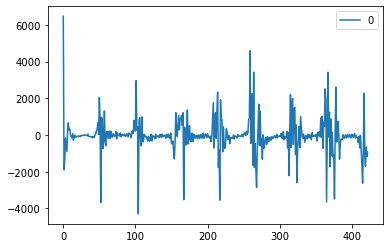

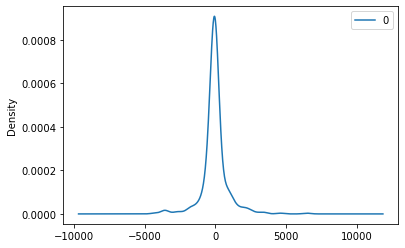

                 0
count   423.000000
mean    -20.901993
std     930.082186
min   -4299.224682
25%    -186.107657
50%     -59.328594
75%      83.018600
max    6474.000000


In [77]:
#fit the model
model = ARIMA(flu_data.ALL_INF, order=(9,1,4), seasonal_order=(1,1,1,52))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [86]:
#Ljung Box Test
sm.stats.acorr_ljungbox(model_fit.resid, lags=[24], return_df=True)


,lb_stat,lb_pvalue
24,7.741848,0.999307


In [87]:
sm.stats.acorr_ljungbox(model_fit.resid, lags=[48], return_df=True)

,lb_stat,lb_pvalue
48,27.377645,0.992751


In [78]:
#plot the residuals

C:\Users\sabri\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sabri\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\sabri\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\sabri\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\sabri\

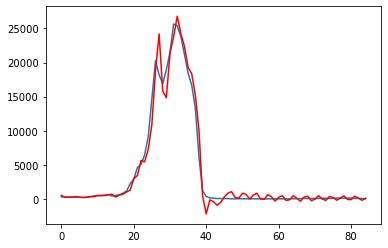

1202.0005028412456

In [88]:
#rolling window ASE
arima_window_ase(flu_data.ALL_INF, train_ratio = .80, order=(9,1,4), seasonal_order=(1,1,1,52))

In [91]:
fc=model_fit.predict(start=339,end=423,dynamic=False)

In [92]:
fc

339     257.828123
340     388.479218
341     425.533704
342     240.416262
343     294.333269
          ...     
419    1760.106087
420     749.353342
421    1225.849920
422     958.115853
423    -584.329613
Length: 85, dtype: float64

In [95]:
flu_data.ALL_INF

0      6474
1      6897
2      5936
3      5130
4      4039
       ... 
418     132
419      67
420      85
421      57
422      22
Name: ALL_INF, Length: 423, dtype: int64